Challenge_1: Aerial Cactus-AML

In [50]:
# Imports
%reset -f
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import wandb
from customDatasets.CactusDataset import CactusDataset
from models.CactusResNet34 import CactusModel
from torch.utils.data import ConcatDataset

In [51]:
log = True
# free gpu
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Phase 1: Loading the data, analyzing it, doing feature engineering and creating the Loader

In [52]:
# load data for displaying
dataset=CactusDataset(root_dir='./data/train/train',labels_path='./data/train.csv')
# take the first sample from train_dataloader
_, train_features, train_labels = dataset[0]
image_np = np.array(train_features)
print("Image shape: "+str(image_np.shape))
print("Image python class"+str(type(train_features)))
print("Label: "+str(train_labels))

Image shape: (32, 32, 3)
Image python class<class 'PIL.JpegImagePlugin.JpegImageFile'>
Label: 1


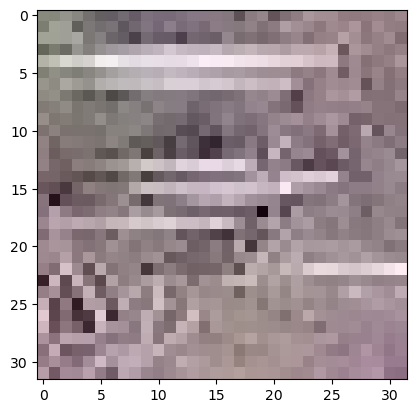

In [53]:
# show the image
plt.imshow(image_np)

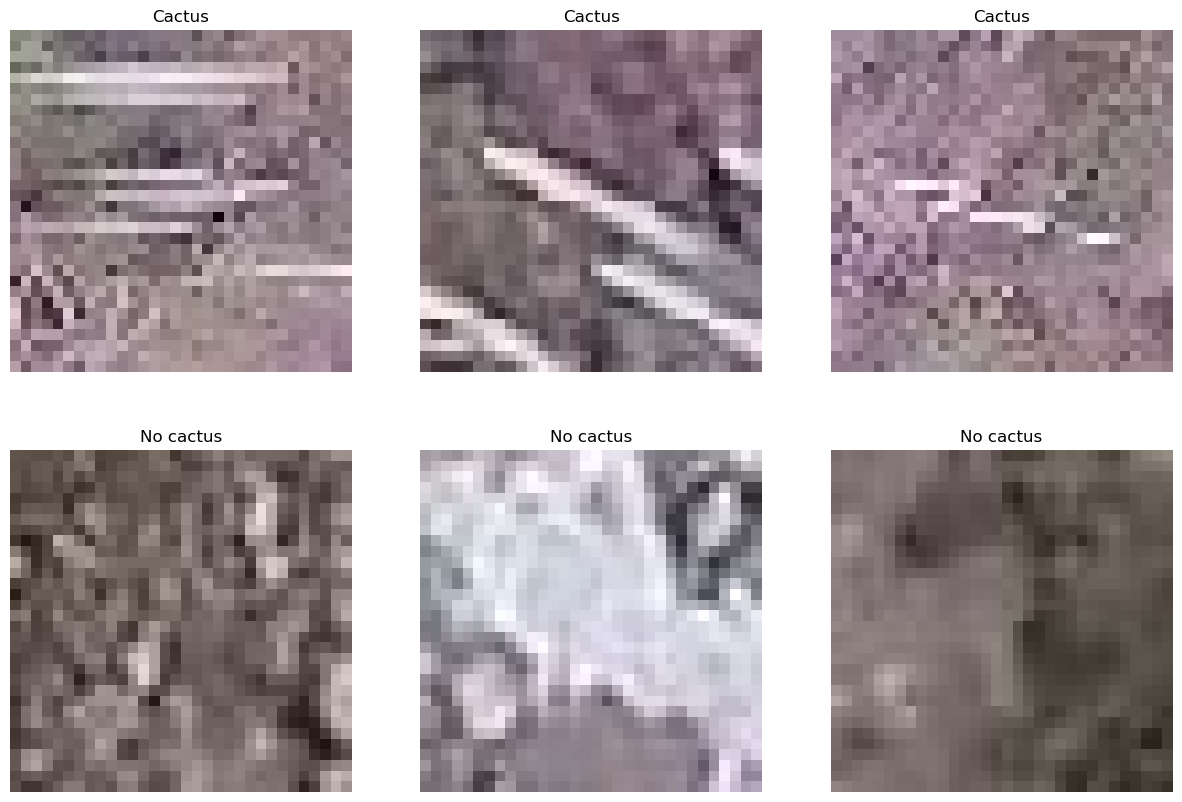

In [54]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Define a transformation to convert PIL image to PyTorch tensor
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

cactus_images = []
no_cactus_images = []
for i in range(len(dataset)):
    _, image, label = dataset[i]
    # Apply the transformation to convert PIL image to PyTorch tensor
    image = transform(image)
    if label == 1 and len(cactus_images) < 3:
        cactus_images.append((image, 1))
    elif label == 0 and len(no_cactus_images) < 3:
        no_cactus_images.append((image, 0))
    if len(cactus_images) == 3 and len(no_cactus_images) == 3:
        break

# Concatenate the vectors
images = cactus_images + no_cactus_images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (image, label) in enumerate(images):
    ax = axes[i // 3, i % 3]
    # Convert the PyTorch tensor back to numpy array and permute dimensions
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title('Cactus' if label == 1 else 'No cactus')
    ax.axis('off')
plt.show()



In [55]:
label_graph=False
if label_graph:
    def get_label_distribution(data):
        label_counts = {}
        for _, _, label in data:
            if label not in label_counts:
                label_counts[label] = 0
            label_counts[label] += 1
        sorted_distribution = sorted(label_counts.items(), key=lambda x: x[0])
        # take only the count
        return [x[1] for x in sorted_distribution]
    label_distribution = get_label_distribution(dataset) # they are sorted in ascending order
    print(label_distribution)
    fig, ax = plt.subplots()
    ax.pie(label_distribution, labels=['no cactus','cactus'], autopct='%1.1f%%')
    plt.show()

In [56]:
graph_gen=False
if graph_gen:
    # Define the transformation
    transform = transforms.Compose([transforms.ToTensor()])
    
    # Load the test dataset
    test_dataset = CactusDataset(root_dir='./data/test/test', labels_path=None, transform=transform)
    
    # Create the data loader for the test dataset
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Load the training dataset
    dataset = CactusDataset(root_dir='./data/train/train', labels_path='./data/train.csv', transform=transform)
    
    # Create the data loader for the training dataset
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    # Compute the average value for each channel and for each pixel in the training set
    mean_train = torch.zeros(3, 32, 32)
    for _, images, _ in dataloader:
        mean_train += images.mean(dim=0)
    mean_train /= len(dataloader)
    
    # Compute the average value for each channel and for each pixel in the test set
    mean_test = torch.zeros(3, 32, 32)
    for _, images, _ in test_dataloader:
        mean_test += images.mean(dim=0)
    mean_test /= len(test_dataloader)
    
    print(mean_train.shape)
    print(mean_test.shape)
    
    # flatten dimensions 2 and 3
    mean_train = mean_train.flatten(1, 2)
    mean_test = mean_test.flatten(1, 2)
    
    print(mean_train.shape)
    print(mean_test.shape)
    
    # create a plot for each channel and put in it x=pixel number and y=value taken from main_train and test_train using histograms
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))
    for i in range(3):
        ax[i].plot(mean_train[i], label='Train')
        ax[i].plot(mean_test[i], label='Test')
        ax[i].set_title(f'Mean value for channel {i}')
        ax[i].set_xlabel('Pixel number')
        ax[i].set_ylabel('Mean value')
        ax[i].legend()

In [57]:
print("Number of train values: "+str(dataset.__len__()))

Number of train values: 17500


Image python class<class 'torch.Tensor'>
Image shape: torch.Size([3, 224, 224])
Label shape: 1


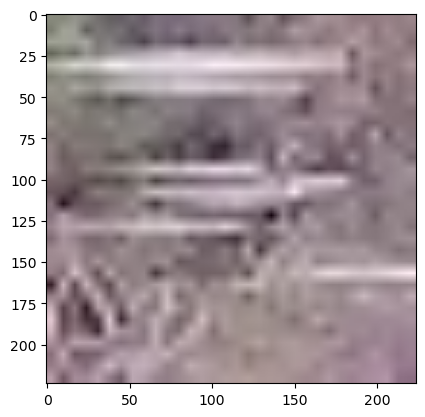

In [58]:
transform_dataset = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = CactusDataset(root_dir="./data/train/train",labels_path="./data/train.csv",transform=transform_dataset)
_, image, label = dataset[0]
print("Image python class"+str(type(image)))
print("Image shape: "+str(image.shape))
print("Label shape: "+str(label))
# show the image
plt.imshow(image.permute(1,2,0))

In [59]:
dataloader=DataLoader(dataset,batch_size=32,shuffle=True)

In [60]:
for i, (img_name, images, labels) in enumerate(dataloader):
    print("Batch number: "+str(i))
    print("Batch image names: "+str(img_name))
    print("Batch images shape: "+str(images.shape))
    print("Batch labels shape: "+str(labels.shape))
    break

Batch number: 0
Batch image names: ('./data/train/train/903b6be9d18e29a937981ea126577ec3.jpg', './data/train/train/2b7a4cec57e9141085d4cb7c4874c9ba.jpg', './data/train/train/2e2883037bcfd4a911bae4294abf6b6a.jpg', './data/train/train/ce0821d66e8b198333cc504b662daf16.jpg', './data/train/train/7fc184b2bc1750bdbd540067522b8c24.jpg', './data/train/train/c0b30e0d804115bec4240c0c657d4081.jpg', './data/train/train/9aadde8d551e329279f51bf17c0b1775.jpg', './data/train/train/f5dacca78c4ea49b90828b739a29b97a.jpg', './data/train/train/c6965f66b718245da9a99293b3805517.jpg', './data/train/train/09ac139695eb518dc20e2d94e4bde4e9.jpg', './data/train/train/80d42d12f7890328dce35013c0d17ee6.jpg', './data/train/train/48314e8bcb6b8387bac5a5c88c304828.jpg', './data/train/train/3dc703d58bd718d5acd4e6d2f41d9c8a.jpg', './data/train/train/bc873e9f5a084b2ff40e322d8dde9fb4.jpg', './data/train/train/602e66a96b907d8848f9b72d189d98d7.jpg', './data/train/train/b33d94683348e922b3d70dcd07a2bf09.jpg', './data/train/train/

In [61]:
# select a few samples from the dataset in order to have 3 cactus and 3 no cactus images
cactus_images = []
no_cactus_images = []
for i in range(len(dataset)):
    _, image, label = dataset[i]
    if label == 1 and len(cactus_images) < 3:
        cactus_images.append((image,1))
    elif label == 0 and len(no_cactus_images) < 3:
        no_cactus_images.append((image,0))
    if len(cactus_images) == 3 and len(no_cactus_images) == 3:
        break
# concatenate the vectors
images = cactus_images + no_cactus_images
'''
from models.LLM import LLM
labeling_model = LLM()
# load the test dataset
test_dataset = CactusDataset(root_dir='./data/test/test', labels_path=None)
# create the data loader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
values=labeling_model.generate_labels(images, test_dataloader)
print(values)
'''

"\nfrom models.LLM import LLM\nlabeling_model = LLM()\n# load the test dataset\ntest_dataset = CactusDataset(root_dir='./data/test/test', labels_path=None)\n# create the data loader\ntest_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)\nvalues=labeling_model.generate_labels(images, test_dataloader)\nprint(values)\n"

In [62]:
# --------- DATA AUGMENTATION ---------
# filter the dataset to only have no cactus images
dataset = CactusDataset(root_dir="./data/train/train",labels_path="./data/train.csv",transform=transform_dataset)
no_cactus_dataset = dataset.filter(0)
# create a concatenated dataset with an equal number of cactus and no cactus images
print("Number of no cactus images: "+str(no_cactus_dataset.__len__()))
print("Number of cactus images: "+str(dataset.__len__()-no_cactus_dataset.__len__()))
def compute_mean_std(dataset):
    mean = 0.
    std = 0.
    for _, images, _ in dataset:
        mean += images.mean()
        std += images.std()
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std
mean, std = compute_mean_std(ConcatDataset([dataset, no_cactus_dataset, no_cactus_dataset]))
print("Mean: "+str(mean))
print("Std: "+str(std))
# load test_dataset and we do the same
mean_test, std_test = compute_mean_std(CactusDataset(root_dir="./data/test/test",labels_path=None,transform=transform_dataset))
print("Mean test: "+str(mean_test))
print("Std test: "+str(std_test))

Number of no cactus images: 4364
Number of cactus images: 13136
Mean: tensor(0.4809)
Std: tensor(0.0906)
Mean test: tensor(0.3982)
Std test: tensor(0.0898)


In [63]:
torch.manual_seed(42)
merged_dataset_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

dataset=CactusDataset(root_dir="./data/train/train",labels_path="./data/train.csv",transform=merged_dataset_transforms)
no_cactus_dataset=dataset.filter(0)
dataset_merged=ConcatDataset([dataset,no_cactus_dataset,no_cactus_dataset])

In [64]:
# --------- CREATING THE DATA LOADER AND TRAIN/VAL SPLIT ---------
torch.manual_seed(42)
dataset_used=dataset_merged
train_size = int(0.7 * len(dataset_used))
print("Train size: " + str(train_size))
test_size = len(dataset_used) - train_size
print("Test size: " + str(test_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset_used, [train_size, test_size])

# Retrieve the lengths of the datasets
print("dataset length: " + str(len(dataset_used)))


# Create DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,pin_memory=True)
#print a sample
_, image,label=dataset_used.__getitem__(0)
print("Image shape: "+str(image.shape))
print("Label shape: "+str(label))

Train size: 18359
Test size: 7869
dataset length: 26228
Image shape: torch.Size([3, 224, 224])
Label shape: 1



 # Phase 2: defining the model

In [65]:
if log:
    # setting wandb
    wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [66]:
if log:
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="Challenge_1",
    
        # track hyperparameters and run metadata
        config={
        "architecture": "ResNet34_FineTuned",
        "dataset": "Cactus",
        "freeze_epochs": 2,
        "freeze_learning_rate": 0.01,
        "epochs": 5,
        "learning_rate": 0.001,
        "batch_size": 32,
        }
    )

epoch,▁█
loss train,▁█
loss val,█▁
epoch,1
loss train,0.10153
loss val,0.0224


In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CactusModel()
model.to(device)
print(model)

CactusModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [68]:
# train the model
import os
if log:
    # Create DataLoader for training and validation
    train_dataloader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    if not os.path.exists('./weights/cactus_model.pth'):
        model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.freeze_epochs, lr=wandb.config.freeze_learning_rate, device=device, wandb=wandb, freeze=True)
    model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.epochs, lr=wandb.config.learning_rate, device=device, wandb=wandb)

Training on: cuda
Epoch: 0 Loss train: 0.2210128420301898
Epoch: 0 Loss val: 0.08336350948708814
Epoch: 1 Loss train: 0.20466695485948114
Epoch: 1 Loss val: 0.07461160493397524
Training on: cuda
Epoch: 0 Loss train: 0.17224879395979284
Epoch: 0 Loss val: 0.06611130646384053
Epoch: 1 Loss train: 0.11201155539534098
Epoch: 1 Loss val: 0.04261146249362769
Epoch: 2 Loss train: 0.08567875531950726
Epoch: 2 Loss val: 0.038678449645595005
Epoch: 3 Loss train: 0.07184777030392932
Epoch: 3 Loss val: 0.03156615101073381
Epoch: 4 Loss train: 0.06378029888613664
Epoch: 4 Loss val: 0.02725995350234182


In [69]:
do_cm=True

def calculate_cm(dataloader, model, device, threshold=0.5):
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for (image_names, images, labels) in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.round(torch.sigmoid(outputs))
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
    return confusion_matrix(all_labels, all_predictions)

if do_cm:
    from sklearn.metrics import confusion_matrix
    print("Generating confusion matrix")
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True)
    # Get confusion matrices
    train_cm = calculate_cm(train_dataloader, model, device)
    val_cm = calculate_cm(val_dataloader, model, device)
    
    print("Training Confusion Matrix:")
    print(train_cm)
    print("Validation Confusion Matrix:")
    print(val_cm)

Generating confusion matrix
Training Confusion Matrix:
[[9150    7]
 [  48 9154]]
Validation Confusion Matrix:
[[3930    5]
 [   9 3925]]


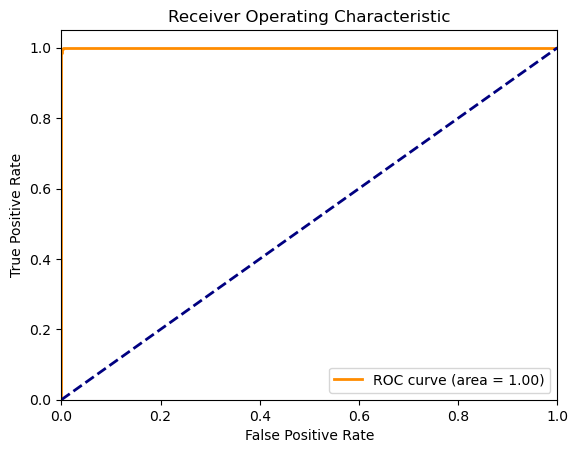

In [70]:
# plot roc curve
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(dataloader, model, device):
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for (image_names, images, labels) in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc_curve(val_dataloader, model, device)

In [71]:
# generate fscore, recall and precision
from sklearn.metrics import precision_score, recall_score, f1_score
def calculate_metrics(dataloader, model, device):
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for (image_names, images, labels) in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.round(torch.sigmoid(outputs))
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    fscore = f1_score(all_labels, all_predictions)
    return precision, recall, fscore

train_precision, train_recall, train_fscore = calculate_metrics(train_dataloader, model, device)
val_precision, val_recall, val_fscore = calculate_metrics(val_dataloader, model, device)
print("Training Precision: {:.2f}".format(train_precision))
print("Training Recall: {:.2f}".format(train_recall))
print("Training F1 Score: {:.2f}".format(train_fscore))
print("Validation Precision: {:.2f}".format(val_precision))
print("Validation Recall: {:.2f}".format(val_recall))
print("Validation F1 Score: {:.2f}".format(val_fscore))

Training Precision: 1.00
Training Recall: 1.00
Training F1 Score: 1.00
Validation Precision: 1.00
Validation Recall: 1.00
Validation F1 Score: 1.00


In [72]:
if log:
    # use it to classify the test
    test_transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    # load the test dataset
    test_dataset = CactusDataset(root_dir='./data/test/test', labels_path=None, transform=test_transform)
    # create the data loader
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    out=model.predict_model(test_dataloader, device, './data/submission.csv')
    print(out)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size

In [73]:
# now using custom made resnet34
from models.CustomResNet34 import CustomResNet34
train_custom=True
model = CustomResNet34()
model.to(device)
print(model)

CustomResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (basic_block1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (basic_block2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(

In [74]:
if train_custom==True:
    wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [75]:
if train_custom==True:
    wandb.init(
        project="Challenge_1",
        config={
        "architecture": "ResNet34_CustomMade",
        "dataset": "Cactus",
        "epochs": 3,
        "learning_rate": 0.01,
        "batch_size": 32,
        }
    )

epoch,▁▃▁▃▅▆█
loss train average,█▇▆▃▂▁▁
loss val average,█▇▆▃▂▂▁
epoch,4
loss train average,0.06378
loss val average,0.02726


In [76]:
# train the model
if train_custom==True:
    train_dataloader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.epochs, lr=wandb.config.learning_rate, device=device, wandb=wandb)

Training on: cuda
Epoch: 0 Loss train: 0.04871348291635513
Epoch: 0 Loss val: 0.6418934464454651
Epoch: 1 Loss train: 0.16855281591415405
Epoch: 1 Loss val: 0.10208045691251755
Epoch: 2 Loss train: 0.049649447202682495
Epoch: 2 Loss val: 0.018508989363908768


In [77]:
do_cm=True

def calculate_cm(dataloader, model, device, threshold=0.5):
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for (image_names, images, labels) in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.round(torch.sigmoid(outputs))
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
    return confusion_matrix(all_labels, all_predictions)


if do_cm:
    from sklearn.metrics import confusion_matrix
    print("Generating confusion matrix")
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True)
    # Get confusion matrices
    train_cm = calculate_cm(train_dataloader, model, device)
    val_cm = calculate_cm(val_dataloader, model, device)
    
    print("Training Confusion Matrix:")
    print(train_cm)
    print("Validation Confusion Matrix:")
    print(val_cm)

Generating confusion matrix
Training Confusion Matrix:
[[9073   84]
 [ 773 8429]]
Validation Confusion Matrix:
[[3888   47]
 [ 311 3623]]


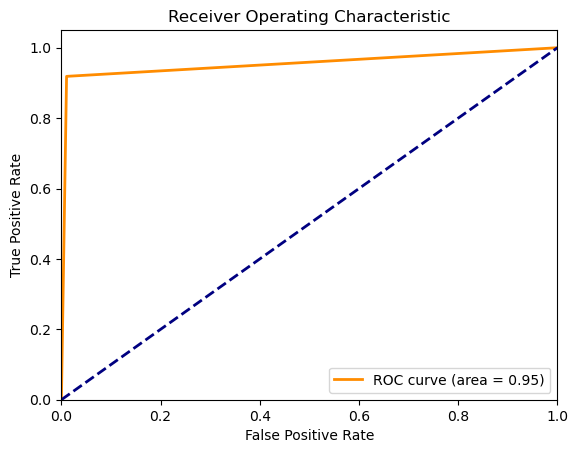

In [78]:
# generate roc curve plot
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(dataloader, model, device):
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for (image_names, images, labels) in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            outputs = torch.round(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(val_dataloader, model, device)

In [79]:
# generate fscore, recall and precision
from sklearn.metrics import precision_score, recall_score, f1_score
def calculate_metrics(dataloader, model, device):
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for (image_names, images, labels) in dataloader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.round(torch.sigmoid(outputs))
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    fscore = f1_score(all_labels, all_predictions)
    return precision, recall, fscore

train_precision, train_recall, train_fscore = calculate_metrics(train_dataloader, model, device)
val_precision, val_recall, val_fscore = calculate_metrics(val_dataloader, model, device)
print("Training Precision: {:.2f}".format(train_precision))
print("Training Recall: {:.2f}".format(train_recall))
print("Training F1 Score: {:.2f}".format(train_fscore))
print("Validation Precision: {:.2f}".format(val_precision))
print("Validation Recall: {:.2f}".format(val_recall))
print("Validation F1 Score: {:.2f}".format(val_fscore))

Training Precision: 0.99
Training Recall: 0.92
Training F1 Score: 0.95
Validation Precision: 0.99
Validation Recall: 0.92
Validation F1 Score: 0.95
